In [3]:
!pip install xgboost

  Using cached xgboost-2.1.4-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached nvidia_nccl_cu12-2.25.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 3.7 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 MB 2.3 MB/s eta 0:00:0000:0100:03


In [4]:
%matplotlib inline
import sklearn as sk
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn import metrics

import joblib


In [2]:
#streamlit-es importok
import streamlit as st


In [5]:
dataset = pd.read_csv("data.csv")
dataset

,Age,Gender,Education,Introversion Score,Sensing Score,Thinking Score,Judging Score,Interest,Personality
0,19.0,Male,0,9.47080,7.141434,6.03696,4.360278,Unknown,ENFP
1,27.0,Female,0,5.85392,6.160195,0.80552,4.221421,Sports,ESFP
2,21.0,Female,0,7.08615,3.388433,2.66188,5.127320,Unknown,ENFP
3,28.0,Male,0,2.01892,4.823624,7.30625,5.986550,Others,INTP
4,36.0,Female,1,9.91703,4.755080,5.31469,4.677213,Technology,ENFP
...,...,...,...,...,...,...,...,...,...
128056,27.0,Male,0,5.11456,7.764336,5.72341,2.686904,Arts,ESTP
128057,19.0,Male,0,3.00078,2.525392,4.71081,3.657814,Unknown,INFP
128058,26.0,Female,1,8.16219,3.433857,2.45531,5.541144,Arts,ENFP
128059,24.0,Male,0,9.37782,5.077443,1.79598,6.762643,Unknown,ENFJ


In [6]:
print(dataset["Interest"].nunique()) #5 fele interest
print(dataset["Personality"].nunique()) # 16 fele personality

5
16


In [7]:
dataset["Gender"] = dataset["Gender"].map({'Female': 1, 'Male': 0})
le = LabelEncoder()
dataset["Interest"] = le.fit_transform(dataset["Interest"])
le_interrest_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_interrest_mapping)
dataset["Personality"] = le.fit_transform(dataset["Personality"])
le_personality_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_personality_mapping)


{'Arts': 0, 'Others': 1, 'Sports': 2, 'Technology': 3, 'Unknown': 4}
{'ENFJ': 0, 'ENFP': 1, 'ENTJ': 2, 'ENTP': 3, 'ESFJ': 4, 'ESFP': 5, 'ESTJ': 6, 'ESTP': 7, 'INFJ': 8, 'INFP': 9, 'INTJ': 10, 'INTP': 11, 'ISFJ': 12, 'ISFP': 13, 'ISTJ': 14, 'ISTP': 15}


In [8]:
#balanced sample a diagrammhoz, erdemes utana ujra futtatni az egeszet
target_count = 250
balanced_samples = []

for class_label, group in dataset.groupby('Personality'):
    sample_size = min(len(group), target_count)
    balanced_samples.append(group.sample(n=sample_size, random_state=42))

dataset = pd.concat(balanced_samples).reset_index(drop=True)


In [34]:
print(dataset.head())
print(dataset.describe())
total = dataset["Personality"].count()

print("\nNan values:\n")
print(dataset.isnull().sum())

cnt = dataset["Personality"].value_counts().sort_index()
cnt = cnt.reset_index()
cnt.columns = ['personality', 'count']
cnt['%'] = np.round(cnt['count'] / total * 100, 2)
print("\nPercentage of levels:\n")
print(cnt)

    Age  Gender  Education  Introversion Score  Sensing Score  Thinking Score  \
0  19.0       0          0             9.47080       7.141434         6.03696   
1  27.0       1          0             5.85392       6.160195         0.80552   
2  21.0       1          0             7.08615       3.388433         2.66188   
3  28.0       0          0             2.01892       4.823624         7.30625   
4  36.0       1          1             9.91703       4.755080         5.31469   

   Judging Score  Interest  Personality  
0       4.360278         4            1  
1       4.221421         2            5  
2       5.127320         4            1  
3       5.986550         1           11  
4       4.677213         3            1  
                 Age         Gender      Education  Introversion Score  \
count  128061.000000  128061.000000  128061.000000       128061.000000   
mean       26.349091       0.450012       0.411156            4.996387   
std         4.908022       0.497497    

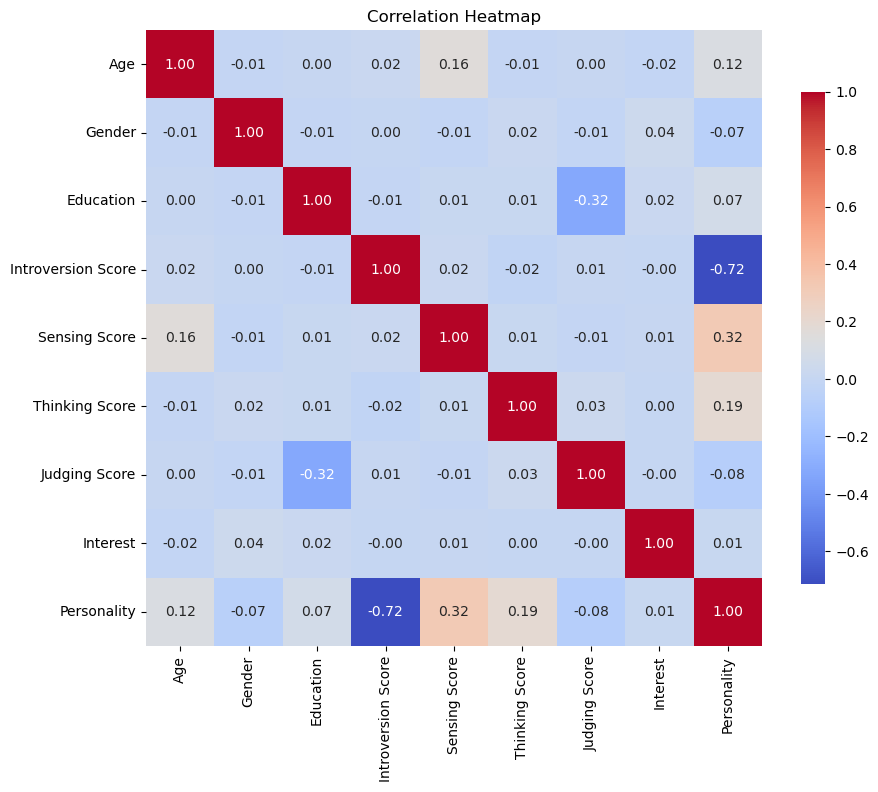

NameError: name 'cnt' is not defined

In [9]:
#adat vizualizacio
correlation_matrix = dataset.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap')
plt.show()
#adatok eloszlasas
plt.figure(figsize=(18,8))

palet = sns.color_palette("crest", len(cnt['personality']))

plt.subplot(1, 2, 1)
barplot = sns.barplot(x=cnt['personality'], y=cnt['count'], palette=palet)

plt.xlabel('Personality')
plt.ylabel('Count')
plt.title('Distribution of Personality types')


for i, row in cnt.iterrows():
    barplot.text(row.name,row['count']/2, int(round(row['count'],2)), color='navy', ha="center")

plt.subplot(1, 2, 2)
plt.pie(cnt['count'], labels=cnt['personality'], autopct='%1.2f%%', colors=palet)

plt.title('Distribution of Personlaity types')
plt.legend(cnt['personality'])
plt.show()


In [21]:
#unbalanced sample:
y = dataset["Personality"]
X = dataset.drop('Personality', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size= 0.8, random_state= 42)

In [10]:
#balanced sample:
target_count = 250
balanced_samples = []

for class_label, group in dataset.groupby('Personality'):
    sample_size = min(len(group), target_count)
    balanced_samples.append(group.sample(n=sample_size, random_state=42))

balanced_df = pd.concat(balanced_samples).reset_index(drop=True)

y= balanced_df["Personality"]
#balanced_df.drop('Introversion Score', axis=1)
X = balanced_df.drop('Personality', axis=1)

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=42)


## tesztuzemkent cnn
## Modell építése
model = Sequential([
    # Dense 1
    Dense(128,activation='relu', input_dim=features.shape[1]),Dropout(0.2),
    # Dense 2
    Dense(64,activation='relu'),Dropout(0.2),
    # Dense 3
    Dense(32,activation='relu'),Dropout(0.2),
    # Dense 4
    Dense(1,activation='linear')
])

# Modell összeállítása
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

In [11]:
#kb 0.84-83 eredmény
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_randomf = accuracy_score(y_test,y_pred)
print("Pontosság:")
print(accuracy_randomf)



Pontosság:
0.8325


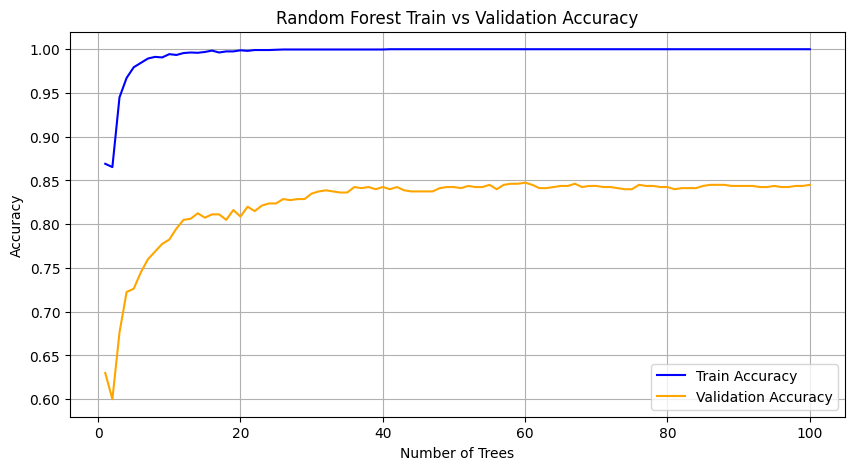

In [13]:
#több változós random forest:

# Random Forest modell inicializálása
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Pontosságok tárolása
train_accuracies = []
val_accuracies = []

# Tanítási ciklus
for n in range(1, 101):
    model.n_estimators = n  # Fák számának beállítása
    model.fit(X_train, y_train)
    
    # Pontosság számítása
    train_acc = accuracy_score(y_train, model.predict(X_train))
    val_acc = accuracy_score(y_test, model.predict(X_test))
    
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

# Grafikon rajzolása
plt.figure(figsize=(10, 5))
plt.plot(range(1, 101), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, 101), val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Random Forest Train vs Validation Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Pontosság:
0.83625


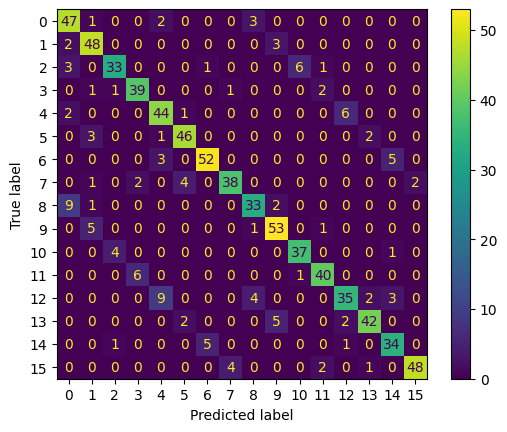

In [14]:
def Display_confm(y_test,y_pred):
    accuracy = accuracy_score(y_test,y_pred)
    conf_matrix = metrics.confusion_matrix(y_pred,y_test)
    print("Pontosság:")
    print(accuracy_randomf)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [0, 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
    cm_display.plot()
    plt.show()

Display_confm(y_test,y_pred)


Legjobb paraméterek: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
0.76125

SVM Eredmények:
              precision    recall  f1-score   support

           0       0.76      0.65      0.70        63
           1       0.76      0.63      0.69        60
           2       0.70      0.77      0.73        39
           3       0.81      0.74      0.78        47
           4       0.78      0.80      0.79        59
           5       0.80      0.83      0.81        53
           6       0.80      0.84      0.82        58
           7       0.69      0.79      0.74        43
           8       0.70      0.76      0.73        41
           9       0.87      0.76      0.81        63
          10       0.81      0.68      0.74        44
          11       0.80      0.76      0.78        46
          12       0.65      0.80      0.71        44
          13       0.77      0.85      0.81        47
          14       0.66      0.77      0.71        43
          15       0.80      0.78      0.7

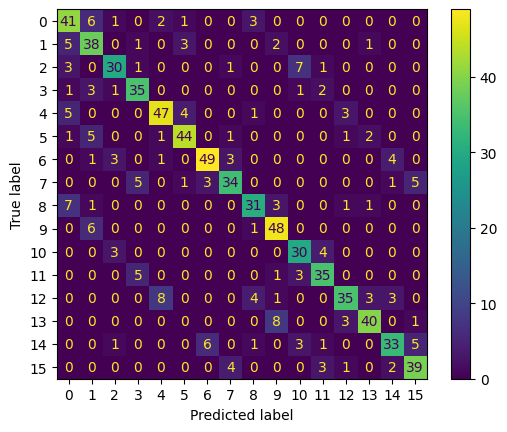

In [15]:
#SVM kb 0.61 acc, gridsearchel: 0.76 kb
#ez gyanusan erzekeny az eletkorra hogy nincs skalazva
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
svm_model = SVC()
svm_grid = GridSearchCV(svm_model, svm_params, cv=5, scoring='accuracy')
svm_grid.fit(X_train, y_train)
y_pred_svm = svm_grid.predict(X_test)

accuracy_svm = accuracy_score(y_test,y_pred_svm)
print("Legjobb paraméterek:", svm_grid.best_params_)
print(accuracy_svm)
print("\nSVM Eredmények:")
print(classification_report(y_test, y_pred_svm))
Display_confm(y_test, y_pred_svm)


C:\Users\majer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [16:23:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\majer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [16:23:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\majer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarnin

Legjobb paraméterek: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 150}
0.85
XGBoost Eredmények:
              precision    recall  f1-score   support

           0       0.88      0.78      0.82        63
           1       0.91      0.83      0.87        60
           2       0.68      0.82      0.74        39
           3       0.95      0.85      0.90        47
           4       0.83      0.76      0.80        59
           5       0.94      0.91      0.92        53
           6       0.91      0.86      0.88        58
           7       0.83      0.91      0.87        43
           8       0.80      0.80      0.80        41
           9       0.84      0.89      0.86        63
          10       0.85      0.80      0.82        44
          11       0.89      0.85      0.87        46
          12       0.67      0.86      0.75        44
          13       0.86      0.89      0.88        47
          14       0.88      0.88      0.88        43
          15       0.90      

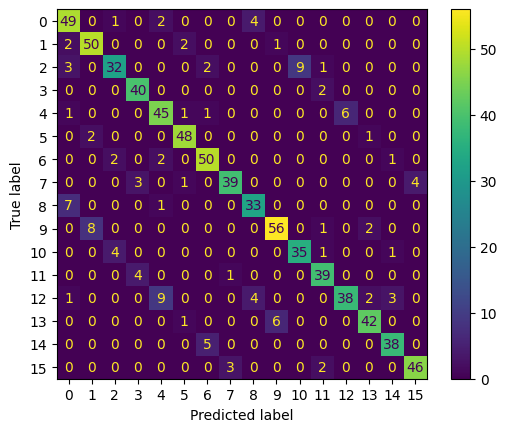

In [16]:
#xgboost kb 0.85 acc
xgb_params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
xgb_model = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='accuracy')
xgb_grid.fit(X_train, y_train)
y_pred_xgb = xgb_grid.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Legjobb paraméterek:", xgb_grid.best_params_)
print(accuracy_xgb)
print("XGBoost Eredmények:")
print(classification_report(y_test, y_pred_xgb))
Display_confm(y_test, y_pred_xgb)


C:\Users\majer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\majer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\majer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\majer\A

0.81625

MLP Eredmények:
              precision    recall  f1-score   support

           0       0.86      0.81      0.84        63
           1       0.84      0.72      0.77        60
           2       0.67      0.90      0.77        39
           3       0.86      0.77      0.81        47
           4       0.83      0.85      0.84        59
           5       0.88      0.83      0.85        53
           6       0.86      0.88      0.87        58
           7       0.74      0.79      0.76        43
           8       0.72      0.80      0.76        41
           9       0.84      0.78      0.81        63
          10       0.82      0.73      0.77        44
          11       0.88      0.80      0.84        46
          12       0.78      0.86      0.82        44
          13       0.80      0.85      0.82        47
          14       0.78      0.93      0.85        43
          15       0.87      0.80      0.83        50

    accuracy                           0.82       800
 

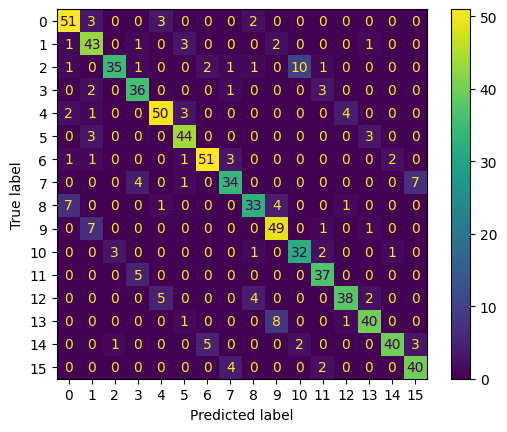

In [17]:
#mpl kb 0.78 acc 82 gridscvel
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'max_iter': [200, 300]
}
mlp_model = MLPClassifier(random_state=42)
mlp_grid = GridSearchCV(mlp_model, mlp_params, cv=5, scoring='accuracy')
mlp_grid.fit(X_train, y_train)
y_pred_mlp = mlp_grid.predict(X_test)

accuracy_mpl = accuracy_score(y_test,y_pred_mlp)
print(accuracy_mpl)
print("\nMLP Eredmények:")
print(classification_report(y_test, y_pred_mlp))
Display_confm(y_test, y_pred_mlp)
